This Notebook is used for testing the 3D-Alignment of generated GAIN domains, clustering and generating a potentially "artificial" GAIN domain used for fitting.

In [158]:
import glob, json
import re
import numpy as np
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

with open('../data/domain_extents.json') as j:
    extents = json.loads(j.read())
struc_file = '../7helix.txt' ##'../14plussheet.txt'# 
allpdbs = glob.glob('../all_pdbs/*.pdb')
with open(struc_file) as h:
    struc_list = h.read().split("\n")
    if len(struc_list[-1]) < 2: struc_list.remove('')
print(len(struc_list))
extent_list = []
realpdbs = []

outfolder = '216_gesamt_files'
bashfile = '../run216gesamt.sh'  #run7gesamt.sh, run14gesamt.sh

for prot in struc_list:
    #print(prot.split("-")[0])
    realpdbs.append([x[3:] for x in allpdbs if prot.split("-")[0] in x][0])
    exlist = extents[prot.split("-")[0]]
    extent_list.append(f"{exlist[0]}-{exlist[1]}") # exlist = [gain.start, gain.subdomain_boundary, gain.end] --> 0,1 for subdomain A - 1,2 for subdomain B
print("Found all filenames.")

n_threads = 6
myct=0
cmd_string = "#!/bin/bash\n"
#for i, prot1 in enumerate(struc_list):
for prot1 in [struc_list[216]]:
    i = 216
    p1name = realpdbs[i]
    #print(p1name)
    if i == len(struc_list): 
        break
    #for j,prot2 in enumerate(struc_list[i+1:]):
    for j,prot2 in enumerate(struc_list):
        #index2 = i+j+1
        index2 = j
        p2name = realpdbs[index2]
        myct +=1
        run_id = f"{i}_{index2}"
        cmd_string += f'/home/hildilab/lib/xtal/ccp4-8.0/bin/gesamt {p1name} -s A/{extent_list[i]} {p2name} -s A/{extent_list[index2]} > {outfolder}/{run_id}.out &\n'
        if myct%n_threads == 0:
            cmd_string +="wait\n"
with open(bashfile,'w') as sh: # 
    sh.write(cmd_string)
print("done.")

432
Found all filenames.
done.


In [148]:
[print(p) for p in realpdbs if "A0A6J" in p]

all_pdbs/A0A6J2UNM3-A0A6J2UNM3_CHACN-LOWQUALITYPROTEIN:AGRD2-like-Chanos_chanos.pdb
all_pdbs/A0A6J0TS53-A0A6J0TS53_9SAUR-AGRD2-Pogona_vitticeps.pdb
all_pdbs/A0A6J2QEW7-A0A6J2QEW7_COTGO-AGRD2-like-Cottoperca_gobio.pdb
all_pdbs/A0A6J3FPX7-A0A6J3FPX7_SAPAP-LOWQUALITYPROTEIN:AGRD2-Sapajus_apella.pdb
all_pdbs/A0A6J0GUV2-A0A6J0GUV2_9PASS-AGRD2-Lepidothrix_coronata.pdb
all_pdbs/A0A6J3E3E3-A0A6J3E3E3_AYTFU-AGRD2-Aythya_fuligula.pdb
all_pdbs/A0A6J3AHN1-A0A6J3AHN1_VICPA-AGRD2-Vicugna_pacos.pdb


[None, None, None, None, None, None, None]

In [149]:

# Build a RMSD matrix of all 7Helix proteins to find the centroid via sum of RMSD
n_prot = len(struc_list)
rmsd_arr = np.full(shape=(n_prot,n_prot), fill_value=6.0)
outfiles = glob.glob('../sda_gesamt_files/*.out')
for f in outfiles:
    with open(f) as ff:
        data = ff.read()
    match = re.search(r"RMSD\W+\:\W+[0-9]+\.[0-9]+",data)
    if match is None:
        print(f, data)
        continue
    val = float(match.group(0)[-5:])
    indices = [int(x) for x in f.split("/")[-1][:-4].split("_")]
    #test
    rmsd_arr[indices[0], indices[1]] = val
    rmsd_arr[indices[1], indices[0]] = val
for k in range(n_prot):
    rmsd_arr[k,k] = 0
    

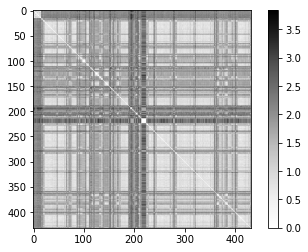

In [150]:

plt.imshow(rmsd_arr, cmap='Greys')
plt.colorbar()
plt.savefig('../sda_7helix_unordered.png', dpi=300)

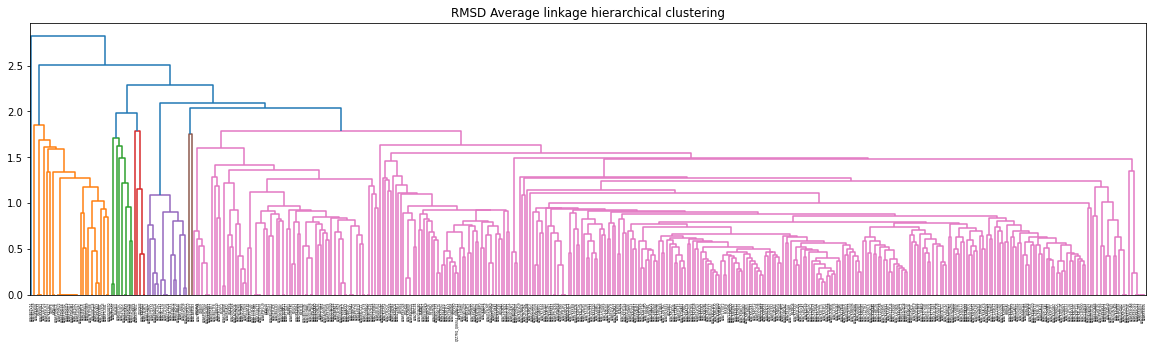

In [151]:


def myname(idx):
    return struc_list[idx-1].split("-")[0]

distances = rmsd_arr

assert np.all(distances - distances.T < 1e-6)
reduced_distances = squareform(distances, checks=False)
linkage = scipy.cluster.hierarchy.linkage(reduced_distances, method='average')
fig = plt.figure(figsize=[20,5])
fig.set_facecolor('w')
plt.title('RMSD Average linkage hierarchical clustering')
_ = scipy.cluster.hierarchy.dendrogram(linkage, leaf_label_func=myname, count_sort='descendent', show_leaf_counts=True, leaf_font_size=3)

plt.savefig("../sda_7cluster.png", dpi=200)

[(0, 294), (294, 367), (367, 397), (397, 400), (400, 404), (404, 412), (412, 415), (415, 431), (431, 432)]
Current cluster: 0 with size 294:
	Centroid: 216
	Name:    A0A7K7IHI9-A0A7K7IHI9_LOXCU-AGRD2protein-Loxia_curvirostra

Current cluster: 1 with size 73:
	Centroid: 307
	Name:    A0A2U9BR74-A0A2U9BR74_SCOMX-PutativeGR144-like-Scophthalmus_maximus

Current cluster: 2 with size 30:
	Centroid: 383
	Name:    A0A6P7M3L7-A0A6P7M3L7_BETSP-AGRD2-likeisoformX5-Betta_splendens

Current cluster: 3 with size 3:
	Centroid: 398
	Name:    A0A851S7Q3-A0A851S7Q3_CERFA-AGRD2protein-Certhia_familiaris

Current cluster: 4 with size 4:
	Centroid: 401
	Name:    A0A674IWP0-A0A674IWP0_TERCA-AGRL4-Terrapene_carolina_triunguis

Current cluster: 5 with size 8:
	Centroid: 408
	Name:    A0A803JAS3-A0A803JAS3_XENTR-AGRF1-Xenopus_tropicalis

Current cluster: 6 with size 3:
	Centroid: 413
	Name:    A0A369RZC0-A0A369RZC0_9METZ-Proteinsidekick-2-Trichoplax_sp._H2.

Current cluster: 7 with size 16:
	Centroid: 422
	Na

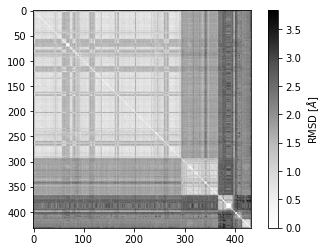

In [152]:
n_cluster = 9

clustering = AgglomerativeClustering(n_clusters=n_cluster, metric='precomputed', 
                        memory=None, connectivity=None, compute_full_tree='auto', linkage='complete', distance_threshold=None, compute_distances=False).fit(distances)
n_struc = n_prot
#print(clustering.labels_)
new_order = np.zeros(shape=(n_struc), dtype=int)
current_num = 0
for i in range(n_cluster):
    for j, cluster_id in enumerate(clustering.labels_):
        if cluster_id == i :
            new_order[j] = current_num
            current_num += 1
#print(new_order)
remap_dict = {old_idx:new_idx for old_idx, new_idx in enumerate(new_order)}
inv_remap_dict = {v:k for k,v in remap_dict.items()}
ordered_distances = np.zeros(shape=(n_struc,n_struc))
for x in range(n_struc):
    new_x = remap_dict[x]
    for y in range(n_struc):
        new_y = remap_dict[y]
        ordered_distances[new_x,new_y] = distances[x,y]

fig = plt.figure(figsize=[6,4])
fig.set_facecolor('w')
plt.imshow(ordered_distances, cmap='Greys')
cbar = plt.colorbar()
cbar.set_label('RMSD [$\AA$]')
plt.savefig('../sda_7helix_clustered.png',dpi=300)


reordered_names = [struc_list[inv_remap_dict[k]] for k in range(n_struc)]
reordered_clusters = [clustering.labels_[inv_remap_dict[k]] for k in range(n_struc)]


_, cluster_starts = np.unique(reordered_clusters, return_index = True)
cluster_intervals = [(cluster_starts[k], cluster_starts[k+1]) for k in range(n_cluster-1)]
cluster_intervals.append((cluster_starts[-1], n_struc))
print(cluster_intervals)

for cl_idx, cluster in enumerate(cluster_intervals):
    best_struc = cluster[0]+np.argmin(np.sum(ordered_distances[ cluster[0]:cluster[1] , cluster[0]:cluster[1] ], axis=0))
    print(f"Current cluster: {cl_idx} with size {cluster[1]-cluster[0]}:\n\tCentroid: {best_struc}\n\tName:    {reordered_names[best_struc]}\n")

overall_best = np.argmin(np.sum(ordered_distances[ : , : ], axis=0))

print(f"All structures:\n\tCentroid: {overall_best}\n\tName:    {reordered_names[overall_best]}\n")


In [153]:
df = pd.DataFrame(ordered_distances, index = list(reordered_names), columns = list(reordered_names))
df = df.to_json(orient='index')
with open("../sdb_7helix_data.json",'w') as c:
    c.write(json.dumps(df))


In [154]:
import shutil
for pdb in realpdbs:
        shutil.copyfile(f'../{pdb}', f'../sda_pdbs/{pdb.split("/")[-1]}')